In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import collections  as mc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
from astropy.io import ascii, fits
import math, os, glob
import itertools

#optional dependencies
from distutils.spawn import find_executable
if find_executable('latex'): rc('text', usetex=True)
else: rc('text', usetex=False)
    
from reduction import reduce, plotImg
from centroid import dist, centroid
from query import usno, selectField
from coordinates import *

### Demo data and old centroid routine

In [2]:
# red = reduce(dataf='data/demo/d159.fits', flatf='data/demo/d121.fits')

In [3]:
# perc = 99.8
# star_pts = findStar(red, perc=perc)

# bad_col = [255, 256] + list(np.arange(1000,1025))
# ptlist = removePixels(star_pts, cols=bad_col)

# clusters = clusterPoints(ptlist, radius=5)
# peak_pixels = findClusterMax(red, clusters)
# centroids = centroid(red, peak_pixels, radius=20)

# plotImg(red, pts=ptlist.T, rng=[90,300], title='Points above %s Percentile'%(perc), \
#         save='writeup/plots/identification1.png')
# plotImg(red, pts=peak_pixels.T, rng=[90,300], title='Brightest Cluster Pixels', \
#         save='writeup/plots/identification2.png')
# plotImg(red, pts=centroids.T, rng=[90,300], title='Sub-pixel Centroids', \
#         save='writeup/plots/identification3.png')

In [4]:
# hdr = fits.getheader('data/demo/d158.fits')
# ra0, dec0 = formatRADEC(hdr['RA'], hdr['DEC'])

### Compute centroids for Egeria

(6, 1024, 1024)


/home/jess/Desktop/Academic/PHYS164/lab3/centroid.py:41: RuntimeWarning: invalid value encountered in double_scalars
  x_centroid_err.append((np.sum(y_collapse*(pos_x-x_centroid[i])**2)/(np.sum(y_collapse))**2)**0.5) #errors on centroids
/home/jess/Desktop/Academic/PHYS164/lab3/centroid.py:42: RuntimeWarning: invalid value encountered in double_scalars
  y_centroid_err.append((np.sum(x_collapse*(pos_y-y_centroid[i])**2)/(np.sum(x_collapse))**2)**0.5)


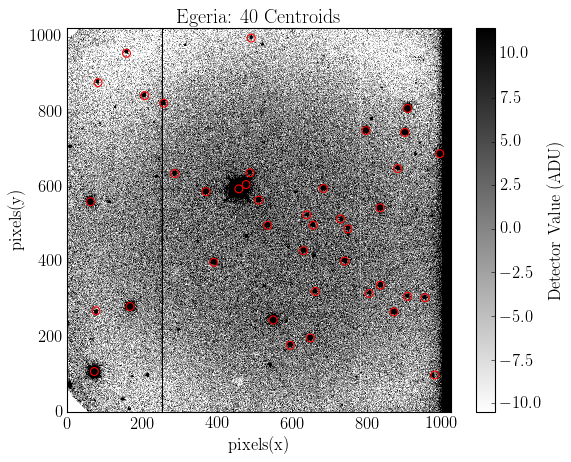

In [5]:
#Read in one raw frame to get header info
rawf  = fits.getheader('data/asteroids/d1038.fits')

#Read in reduced arrays
folder = 'data/egeria/egeria_'
obs    = ['ob1','df1','ob2','df2','ob3','ob4'] #should be in order of time of observation
data   = np.array([np.load(folder+f+'.npy') for f in obs])
data2  = np.array([np.load(folder+f+'.npy') for f in obs])
print(data.shape)

#Compute centroids 
nsources = 40
xccd, yccd = centroid(data[0], nsources=nsources)
plotImg(data2[0], pts=[xccd, yccd], title='Egeria: %s Centroids'%(nsources))

### Query USNO catalog

Calling Vizier http://webviz.u-strasbg.fr/viz-bin/asu-tsv/?-source=USNO-B1&-c.ra=105.295625&-c.dec=45.226222&-c.bm=4.0000000/4.0000000&-out.max=unlimited


/home/jess/Desktop/Academic/PHYS164/lab3/query.py:63: RuntimeWarning: invalid value encountered in less
  w = np.where(rmag < rcut)[0] # select only bright stars r < 15 mag.


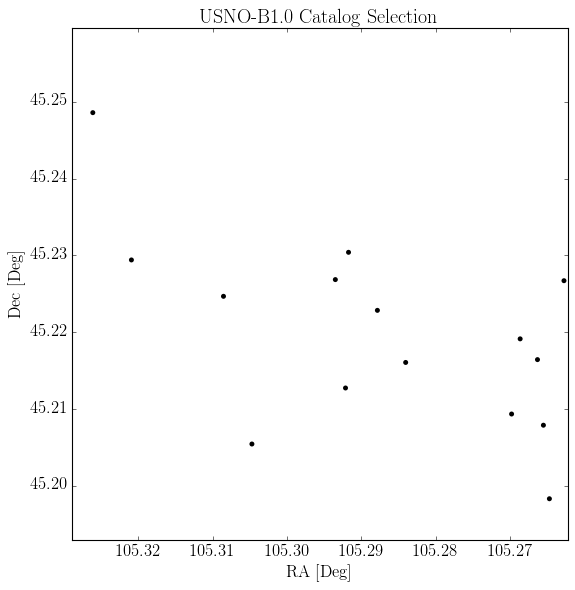

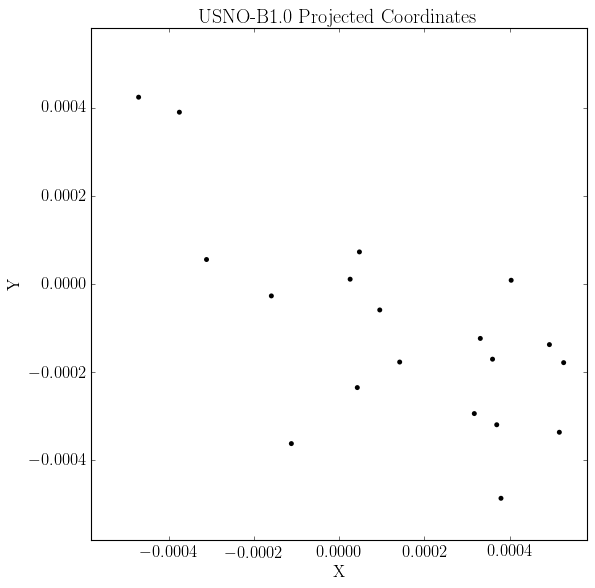

In [6]:
rmag  = 18
fovam = 4
ra0, dec0 = formatRADEC(rawf['RA'], rawf['DEC'])

#Select field from USNO catalog
name, rad, ded, rmag = selectField(ra0, dec0, fovam=fovam, rmag=rmag, plot=True)

#Convert to projected coordinates
Xusno, Yusno = angleToProjected(ra0=ra0, dec0=dec0, ra=rad, dec=ded, fovam=fovam, plot=True)

### Match CCD and USNO sources in pixel coordinates

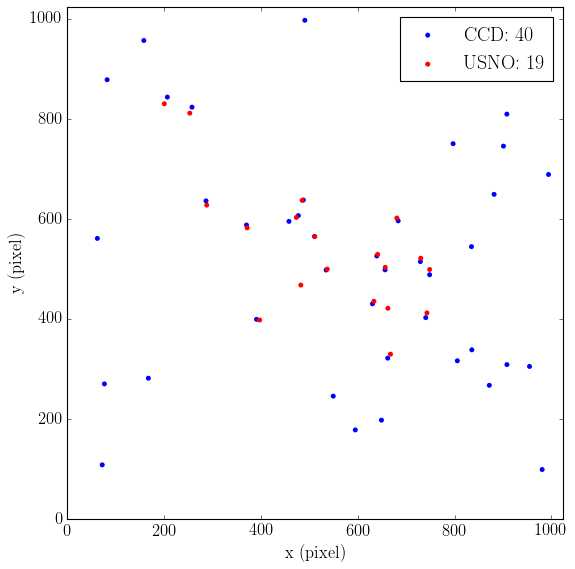

In [7]:
#Convert to pixel coordinates using ideal transformation
xusno_ideal, yusno_ideal = projectedToPixelIdeal(Xusno, Yusno, f_p=16480/(2*0.015), x0=459, y0=598)

plt.figure(figsize=[8,8])
plt.scatter(xccd, yccd, color='b', edgecolor='none', label='CCD: %s'%(len(xccd)))
plt.scatter(xusno_ideal, yusno_ideal, color='r', edgecolor='none', label='USNO: %s'%(len(xusno_ideal)))
plt.xlim(0,1024)
plt.ylim(0,1024)
plt.xlabel('x (pixel)')
plt.ylabel('y (pixel)')
plt.legend(loc='upper right', scatterpoints=1)
plt.show()

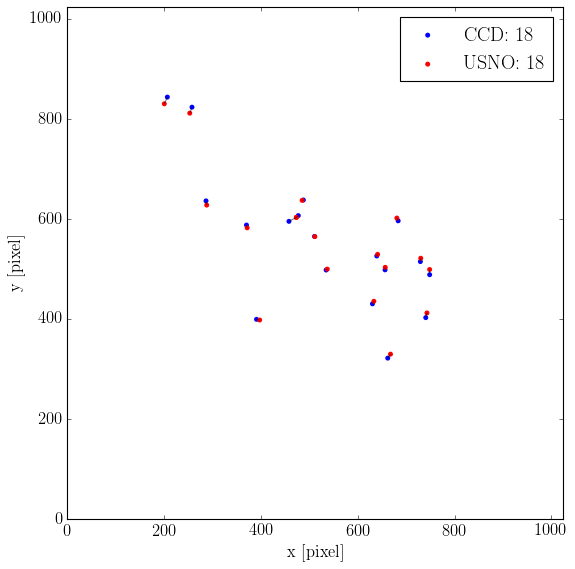

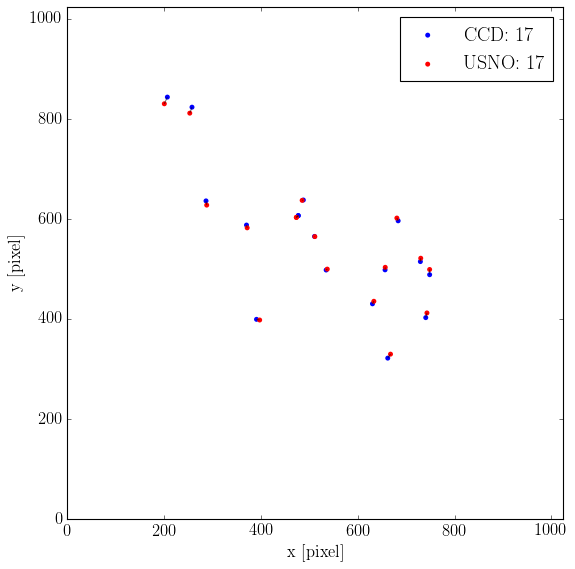

In [8]:
xccd_match, yccd_match, xusno_match, yusno_match = matchCoord(xccd, yccd, xusno_ideal, yusno_ideal, thres=20)
plotMatch(xccd_match, yccd_match, xusno_match, yusno_match)

xm1, ym1, xm2, ym2 = removeMatches(xccd_match, yccd_match, xusno_match, yusno_match)
plotMatch(xm1, ym1, xm2, ym2)

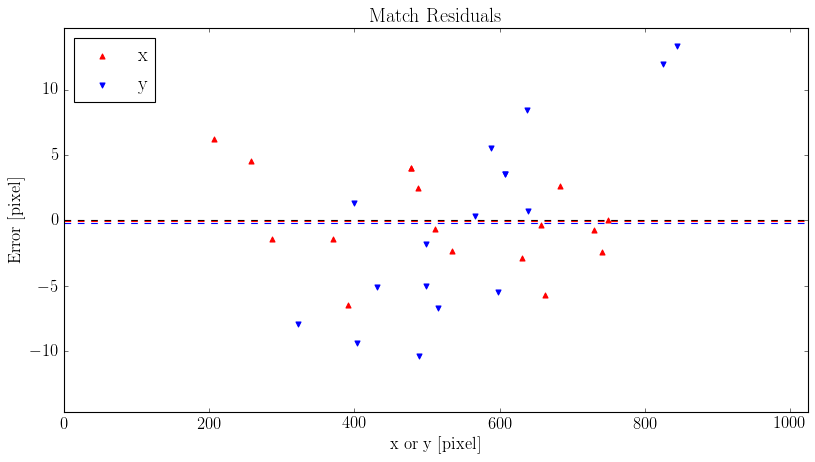

In [9]:
plotResiduals(xm1, ym1, xm2, ym2, unit='pixel', title='Match Residuals')

### Solve for plate constants, convert CCD to RA/DEC

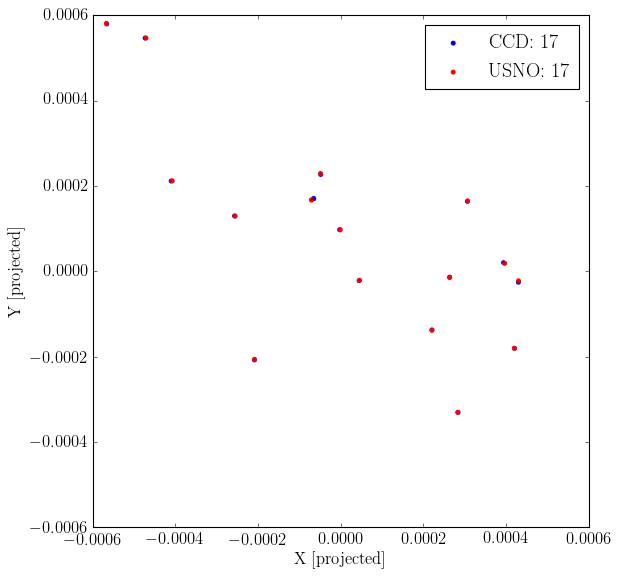

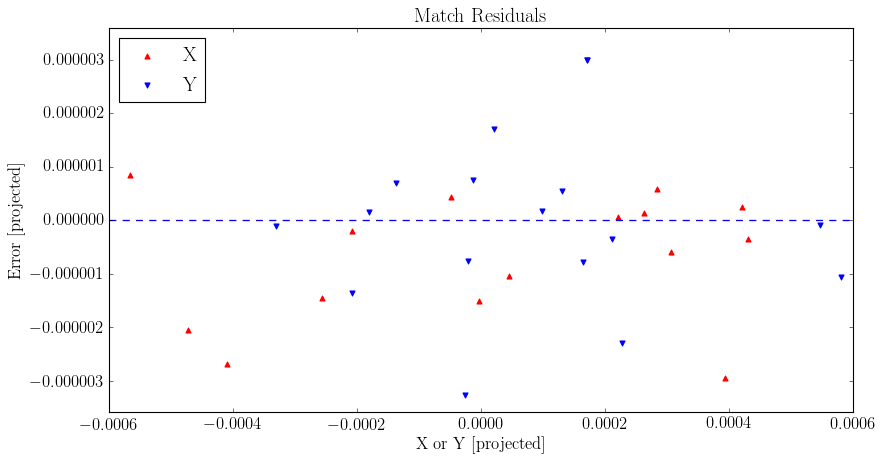

In [46]:
Xm_usno, Ym_usno = projectedToPixelIdealInv(xm2, ym2, f_p=16480/(2*0.015))

Xm_ccd, Ym_ccd = projectedToPixel(xm1, ym1, Xm_usno, Ym_usno, f_p=190020)

plotMatch(Xm_ccd, Ym_ccd, Xm_usno, Ym_usno, dim=[-.0006, .0006], lbl=['X', 'Y'], unit='projected')
plotResiduals(Xm_ccd, Ym_ccd, Xm_usno, Ym_usno, unit='projected', lbl=['X', 'Y'], \
              xlim=[-.0006, .0006], title='Match Residuals')

In [73]:
Xccd, Yccd = projectedToPixel(xm1, ym1, Xm_usno, Ym_usno, f_p=190020, xtrans=xccd, ytrans=yccd)
Rccd, Dccd = projToSky(-Xccd, Yccd, ra0, dec0)

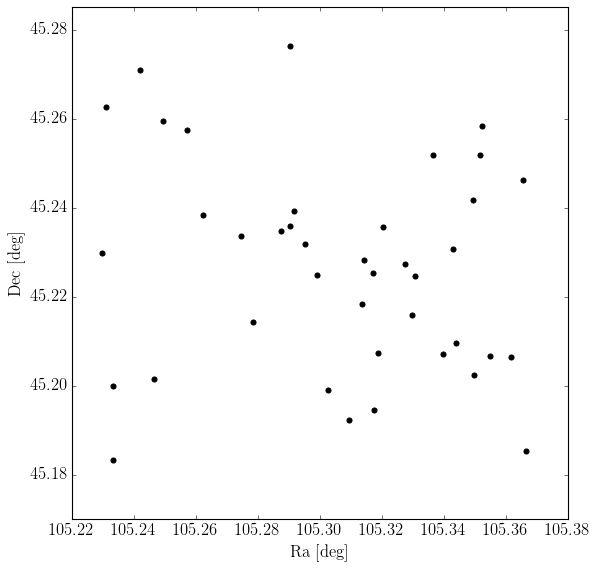

In [79]:
plt.figure(figsize=[8,8])
plt.scatter(Rccd, Dccd, color='k')
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Ra [deg]')
plt.ylabel('Dec [deg]')
plt.xlim(105.22,105.38)
plt.ylim(45.17,45.285)
plt.show()